In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

df = pd.read_csv('train.csv')

In [84]:
df['FamilySize'] = df['SibSp'] + df['Parch']

df['NameLength'] = df['Name'].apply(lambda x: len(x))

In [85]:
#getting title from Name column
def get_title(name):
    #Use a regular expression to search for title. titles always consist of capital and lowercase letters, and end with prediod.
    title_search = re.search(' ([A-Za-z]+)\.',name)
    #if the title exist, extract and return it
    if title_search:
        return title_search.group(1)
    return ''

In [86]:
#get all the titles and print how often each one occurs
titles = df['Name'].apply(get_title)
print(pd.value_counts(titles))

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64


In [87]:
#map each title to an integer.some titles are rare,and are compressed into the same codes as other titles.
title_mapping = {'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Dr':5,'Rev':5,'Col':5,'Major':5,'Mlle':2,'Countess':5,
                 'Ms':2,'Lady':5,'Jonkheer':5,'Don':5,'Mme':2,'Capt':5,'Sir':5}
titles = titles.map(title_mapping)

In [89]:
df['Title'] = titles

In [90]:
import operator

#A dictionary mapping family name to id
family_id_mapping = {}
#A function to get the id given a row
def get_family_id(row):
    #Find the last name by splitting on a comma
    last_name = row['Name'].split(',')[0]
    #Create the family id
    family_id = '{0}{1}'.format(last_name, row['FamilySize'])
    #Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            #Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(),key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]
#Get the family ids with the apply method
family_ids = df.apply(get_family_id,axis=1)

family_ids[df['FamilySize'] < 2] = -1

df['FamilyId'] = family_ids

In [100]:
#convert sex
sex_mapping = {'female':0,'male':1}
df['Sex'] = df['Sex'].map(sex_mapping)

In [101]:
#insert missing age values , using median value
from sklearn.preprocessing import Imputer
imr_age = Imputer(missing_values='NaN',strategy='median',axis=0)
imr_age.fit(df[['Age']].values)
df['Age'] = imr_age.transform(df[['Age']].values)

In [103]:
#Next parameter is Embarked.strategy is frequent so recreate Imputer object
imr = Imputer(missing_values='NaN',strategy='most_frequent')
#Imputer only can numeric values ,so convert str into numeric using map function
#create dictionary
embarked_mapping = {'C':1,'Q':2,'S':3}
#convert usinig map function
embarked_int = df['Embarked'].map(embarked_mapping)
#Imputing
df['Embarked'] = imr.fit_transform(embarked_int[:,np.newaxis])

In [107]:
features = [u'Pclass',u'Sex', u'Age',u'SibSp', u'Parch', u'Fare', u'Embarked'
            ,u'FamilySize', u'NameLength', u'Title', u'FamilyId']
X = df[features].values
y = df['Survived']

In [113]:
#analysis importance of features using random forest
from sklearn.ensemble import RandomForestClassifier
#name of features
feat_labels = np.array(features)
# craete random forest object
forest = RandomForestClassifier(n_estimators=500,random_state=0,n_jobs=-1)
#fitting the model
forest.fit(X,y)
#extract importance of features
importances = forest.feature_importances_
#extract index of features importance with decend
indices = np.argsort(importances)[::-1]
#print importances
for i in range(X.shape[1]):
    print('%2d) %-*s %f') %(i+1,30,feat_labels[indices[i]],importances[indices[i]])

 1) Fare                           0.179711
 2) NameLength                     0.161084
 3) Title                          0.157541
 4) Age                            0.150108
 5) Sex                            0.133963
 6) Pclass                         0.072532
 7) FamilySize                     0.041394
 8) FamilyId                       0.032913
 9) Embarked                       0.028281
10) SibSp                          0.026758
11) Parch                          0.015715


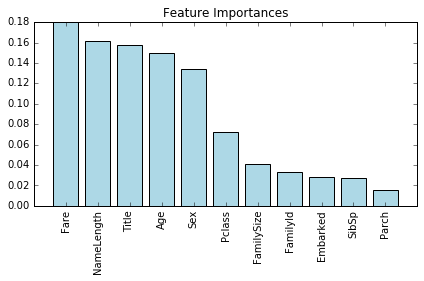

In [114]:
#plot features importances
plt.title('Feature Importances')
plt.bar(range(X.shape[1]),importances[indices],color='lightblue',align='center')
plt.xticks(range(X.shape[1]),feat_labels[indices],rotation=90)
plt.xlim([-1,X.shape[1]])
plt.tight_layout()
plt.show()